<a href="https://colab.research.google.com/github/Lee-Gunju/AI-contest/blob/master/%5BDacon%5Dresnet_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install rdkit-pypi


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader

import gdown
import re
import zipfile
import tensorflow as tf
from tensorflow import keras 


In [4]:
print('numpy verison :', np.__version__)
print('pandas version :', pd.__version__)
print('opencv version :', cv2.__version__)
print('rdkit version :', rdkit.__version__)
print('torch version :', torch.__version__)

numpy verison : 1.19.5
pandas version : 1.1.5
opencv version : 4.1.2
rdkit version : 2021.03.5
torch version : 1.9.0+cu102


In [9]:
url = "https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z"

In [10]:
## data download 받고(gdown.download 사용) 압축 풀기
gdown.download(url, 'data.zip', quiet=False)

with zipfile.ZipFile('data.zip', 'r') as z_fp:
  z_fp.extractall('./data')

Downloading...
From: https://drive.google.com/u/0/uc?export=download&confirm=ynH9&id=1WcW8SbDvkEwtoMR1pOrYeWNa62uYEm9z
To: /content/data.zip
32.0MB [00:00, 281MB/s]


In [11]:
train = pd.read_csv('./data/train.csv')
dev = pd.read_csv('./data/dev.csv')

In [12]:
! dir
#path = "data/train_imgs"
!mkdir "data/train_imgs"


data  data.zip	model.png  sample_data
mkdir: cannot create directory ‘data/train_imgs’: File exists


In [13]:
for idx, row in tqdm(train.iterrows()):
    file = row['uid']
    smiles = row['SMILES']
    m = Chem.MolFromSmiles(smiles)
    if m != None:
        img = Draw.MolToImage(m, size=(300,300))
        img.save(f'data/train_imgs/{file}.png')

30274it [06:32, 77.13it/s]


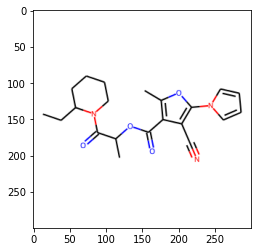

In [14]:
sample_img = cv2.imread('./data/train_imgs/train_0.png')
plt.imshow(sample_img/255.)
plt.show()

In [15]:
import os 
len(os.listdir('./data/train_imgs'))

30274

['train_0.png',
 'train_1.png',
 'train_10.png',
 'train_100.png',
 'train_1000.png',
 'train_10000.png',
 'train_10001.png',
 'train_10002.png',
 'train_10003.png',
 'train_10004.png',
 'train_10005.png',
 'train_10006.png',
 'train_10007.png',
 'train_10008.png',
 'train_10009.png',
 'train_1001.png',
 'train_10010.png',
 'train_10011.png',
 'train_10012.png',
 'train_10013.png',
 'train_10014.png',
 'train_10015.png',
 'train_10016.png',
 'train_10017.png',
 'train_10018.png',
 'train_10019.png',
 'train_1002.png',
 'train_10020.png',
 'train_10021.png',
 'train_10022.png',
 'train_10023.png',
 'train_10024.png',
 'train_10025.png',
 'train_10026.png',
 'train_10027.png',
 'train_10028.png',
 'train_10029.png',
 'train_1003.png',
 'train_10030.png',
 'train_10031.png',
 'train_10032.png',
 'train_10033.png',
 'train_10034.png',
 'train_10035.png',
 'train_10036.png',
 'train_10037.png',
 'train_10038.png',
 'train_10039.png',
 'train_1004.png',
 'train_10040.png',
 'train_10041.png'

In [12]:
image_count = len(os.listdir('./data/train_imgs'))

In [ ]:
data_dir = './data/train_imgs/'
list_ds = tf.data.Dataset.list_files(str(data_dir+'*'), shuffle=False)
labels = train[['S1_energy(eV)', 'T1_energy(eV)']].to_numpy()

#list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
len(labels)

30274

In [ ]:
for i in list_ds.take(3):
  print(i.numpy())

b'./data/train_imgs/train_0.png'
b'./data/train_imgs/train_1.png'
b'./data/train_imgs/train_10.png'


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
img_height = 300
img_width = 300

In [ ]:
def get_label(labels):
  # convert the path to a list of path components
  return labels


def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  #label = get_label(labels)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [ ]:
train_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [ ]:
#val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


tf.Tensor(
[[4.6747 3.3809]
 [3.6617 3.4585]
 [3.642  3.1787]
 ...
 [3.7905 2.605 ]
 [3.5176 2.4248]
 [2.9422 2.2546]], shape=(30274, 2), dtype=float64)


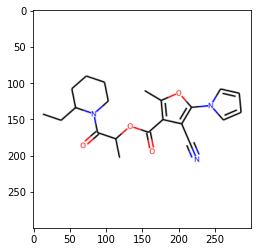

In [ ]:
for i, label in train_ds.take(1):
  print(label)
  plt.imshow(i/255.)


In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  #ds = ds.shuffle(buffer_size=1000)
  #ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
train_ds = configure_for_performance(train_ds)

In [ ]:
labels

In [ ]:
### 여기부터 하면됨!!

In [12]:
os.listdir('./data/train_imgs')

['train_11781.png',
 'train_17904.png',
 'train_15556.png',
 'train_21228.png',
 'train_17148.png',
 'train_4222.png',
 'train_7276.png',
 'train_2559.png',
 'train_2745.png',
 'train_4631.png',
 'train_8291.png',
 'train_19107.png',
 'train_24981.png',
 'train_10814.png',
 'train_6156.png',
 'train_3373.png',
 'train_26138.png',
 'train_15071.png',
 'train_22354.png',
 'train_24425.png',
 'train_10954.png',
 'train_6752.png',
 'train_12777.png',
 'train_22614.png',
 'train_11242.png',
 'train_29522.png',
 'train_9466.png',
 'train_8128.png',
 'train_30050.png',
 'train_16876.png',
 'train_20767.png',
 'train_7913.png',
 'train_20184.png',
 'train_21578.png',
 'train_9242.png',
 'train_28597.png',
 'train_16983.png',
 'train_24530.png',
 'train_4662.png',
 'train_9781.png',
 'train_24137.png',
 'train_8216.png',
 'train_25653.png',
 'train_7978.png',
 'train_18897.png',
 'train_14285.png',
 'train_29372.png',
 'train_5974.png',
 'train_13679.png',
 'train_12517.png',
 'train_8780.png',

In [13]:
a = [i for i in sorted(os.listdir('./data/train_imgs'))]

In [18]:
type(a)

list

In [19]:
a_df = pd.DataFrame(a, columns=['image_name'])
a_df

,image_name
0,train_0.png
1,train_1.png
2,train_10.png
3,train_100.png
4,train_1000.png
...,...
30269,train_9995.png
30270,train_9996.png
30271,train_9997.png
30272,train_9998.png


In [20]:
a_df.image_name.str.split('.').str[0]

0           train_0
1           train_1
2          train_10
3         train_100
4        train_1000
            ...    
30269    train_9995
30270    train_9996
30271    train_9997
30272    train_9998
30273    train_9999
Name: image_name, Length: 30274, dtype: object

In [21]:
a_df['uid'] = a_df.image_name.str.split('.').str[0]

In [22]:
data_dir = './data/train_imgs/'

In [23]:
a_df['image_location'] = data_dir + a_df.image_name

In [24]:
a_df

,image_name,uid,image_location
0,train_0.png,train_0,./data/train_imgs/train_0.png
1,train_1.png,train_1,./data/train_imgs/train_1.png
2,train_10.png,train_10,./data/train_imgs/train_10.png
3,train_100.png,train_100,./data/train_imgs/train_100.png
4,train_1000.png,train_1000,./data/train_imgs/train_1000.png
...,...,...,...
30269,train_9995.png,train_9995,./data/train_imgs/train_9995.png
30270,train_9996.png,train_9996,./data/train_imgs/train_9996.png
30271,train_9997.png,train_9997,./data/train_imgs/train_9997.png
30272,train_9998.png,train_9998,./data/train_imgs/train_9998.png


In [25]:
train

,uid,SMILES,S1_energy(eV),T1_energy(eV)
0,train_0,CCC1CCCCN1C(=O)C(C)OC(=O)c1c(C)oc(-n2cccc2)c1C#N,4.6747,3.3809
1,train_1,COc1ccc(Oc2ccc(N3C(=S)NC(c4ccccn4)C3c3cc(C)n(-...,3.6617,3.4585
2,train_2,CC(=O)Nc1ccc(C(=O)[C@H](C)Sc2nnc(C3CCCCC3)o2)cc1,3.6420,3.1787
3,train_3,OC(CNC1CC1)CN1CCc2sccc2C1,4.8901,3.7847
4,train_4,CCNC(CCCC(F)(F)F)C1(OCC)CCOCC1,6.4967,6.2724
...,...,...,...,...
30269,train_30269,COc1c(/C=N/Nc2ccc(C#N)cc2)ccc2ccccc12,3.7109,2.4774
30270,train_30270,Cc1cc(=O)oc2c3c4c(cc12)CCCN4CCC3,3.8752,2.6624
30271,train_30271,Cc1cc(=O)oc2ccc3ccc(-c4cn(Cc5ccccc5)nn4)cc3c12,3.7905,2.6050
30272,train_30272,CCCCCCN1C(=O)c2cccc3c(-c4cccs4)ccc(c23)C1=O,3.5176,2.4248


In [26]:
train_df = pd.merge(train, a_df, on="uid")
df_shuffled=train_df.sample(frac=1).reset_index(drop=True)
df_shuffled

,uid,SMILES,S1_energy(eV),T1_energy(eV),image_name,image_location
0,train_29914,COc1ccc(-c2nc(-c3ccc(C)cc3)c3ccccn23)cc1,3.3107,2.4300,train_29914.png,./data/train_imgs/train_29914.png
1,train_23958,Cc1cn2cc(-c3cc4ccc(N5CC[C@H]6CNC[C@H]65)cc4oc3...,3.4854,2.4061,train_23958.png,./data/train_imgs/train_23958.png
2,train_13875,CN(C)c1ccc(/C=N/c2n[nH]c(=S)s2)cc1,3.1677,2.2935,train_13875.png,./data/train_imgs/train_13875.png
3,train_21917,CN1CC(NC(=O)Nc2ccc(C(=O)N3CCOCC3)cc2)CCC1=O,4.7422,3.6988,train_21917.png,./data/train_imgs/train_21917.png
4,train_18766,COc1ccc(C(N)C2CCCC2)cc1Br,5.0068,3.9943,train_18766.png,./data/train_imgs/train_18766.png
...,...,...,...,...,...,...
30269,train_28589,CCC1(CC)c2cc(/C=C/c3ccc(N(c4ccccc4)c4ccccc4)cc...,2.7955,2.1003,train_28589.png,./data/train_imgs/train_28589.png
30270,train_6364,CC(C)Cc1ccc(C(Br)C2COC(C)C2)cc1,5.1027,3.8847,train_6364.png,./data/train_imgs/train_6364.png
30271,train_4659,Nc1ccc(Cl)cc1NC(=O)CCSCc1ccco1,4.7035,3.7012,train_4659.png,./data/train_imgs/train_4659.png
30272,train_13528,N#CC1(c2ccccc2)CCC(NCc2ccc(C(=O)O)cc2)CC1,4.4991,3.8492,train_13528.png,./data/train_imgs/train_13528.png


In [27]:
train_df = df_shuffled[:25000]
val_df = df_shuffled[25000:]

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gener =ImageDataGenerator(rescale=1./255.
                           ,validation_split=0.2)

validation_gener = ImageDataGenerator(
        rescale=1.0 / 255)



train_generator = train_gener.flow_from_dataframe(
dataframe=train_df,
x_col="image_location",
y_col=["S1_energy(eV)", 'T1_energy(eV)']	,
batch_size=64,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(300,300))

validation_generator = validation_gener.flow_from_dataframe(
        dataframe=val_df,
        x_col="image_location",
        y_col=["S1_energy(eV)", 'T1_energy(eV)'],
        class_mode="raw",
        target_size=(300,300),
        batch_size=64,
    )



Found 25000 validated image filenames.
Found 5274 validated image filenames.


In [ ]:
a, b = next(iter(train_generator))

In [ ]:
a.shape

(64, 300, 300, 3)

In [ ]:
b.shape

(64, 2)

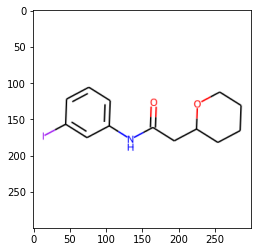

In [ ]:
plt.imshow(a[0])

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(2)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss='mae')

In [ ]:
model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 3,
    verbose = 2
)

Epoch 1/3
391/391 - 69s - loss: 0.7162 - val_loss: 0.6839
Epoch 2/3
391/391 - 64s - loss: 0.6771 - val_loss: 0.7515
Epoch 3/3
391/391 - 63s - loss: 0.6771 - val_loss: 0.6750


In [ ]:
# VIT 
!pip install -U tensorflow-addons

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 9.6 MB/s 


In [ ]:
os.listdir('./data/train_imgs')
train = pd.read_csv('./data/train.csv')

a = [i for i in sorted(os.listdir('./data/train_imgs'))]
a_df = pd.DataFrame(a, columns=['image_name'])

a_df['uid'] = a_df.image_name.str.split('.').str[0]
data_dir = './data/train_imgs/'
a_df['image_location'] = data_dir + a_df.image_name
train_df = pd.merge(train, a_df, on="uid")
df_shuffled=train_df.sample(frac=1).reset_index(drop=True)

train_df = df_shuffled[:25000]
val_df = df_shuffled[25000:]


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gener =ImageDataGenerator(rescale=1./255.
                           ,validation_split=0.2)

validation_gener = ImageDataGenerator(
        rescale=1.0 / 255)



train_generator = train_gener.flow_from_dataframe(
dataframe=train_df,
x_col="image_location",
y_col=["S1_energy(eV)", 'T1_energy(eV)']	,
batch_size=64,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(300,300))

validation_generator = validation_gener.flow_from_dataframe(
        dataframe=val_df,
        x_col="image_location",
        y_col=["S1_energy(eV)", 'T1_energy(eV)'],
        class_mode="raw",
        target_size=(300,300),
        batch_size=64,
    )





Found 25000 validated image filenames.
Found 5274 validated image filenames.


In [ ]:
#device = torch.device("cuda:0")
BATCH_SIZE = 64
EPOCHS = 25
num_layers = 1
dropout_rate = 0.1
embedding_dim = 128
#learning_rate = 1e-4
#vision_pretrain = True
save_path = f'./models/best_model.pt'


learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100
image_size = 300  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

input_shape = (300, 300, 3)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


    

In [ ]:
train_generator.samples

25000

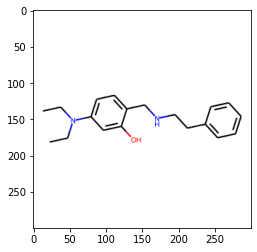

In [ ]:
plt.imshow(image.astype('float32'))

Image size: 300 X 300
Patch size: 20 X 20
Patches per image: 225
Elements per patch: 1200


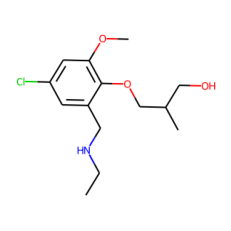

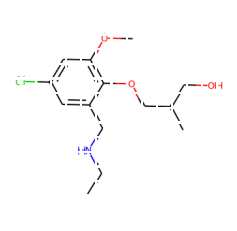

In [ ]:
import matplotlib.pyplot as plt
from keras import layers
plt.figure(figsize=(4, 4))
image, label = iter(next(train_generator))
image = image[0]
plt.imshow(image.astype("float32"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float32"))
    plt.axis("off")

In [ ]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss='mae'
        #metrics=[
        #    keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        #    keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        #],
    )

    # checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )

    history = model.fit(
        train_generator,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data = validation_generator,
        #callbacks=[checkpoint_callback],
    )

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/25
391/391 [==============================] - 97s 226ms/step - loss: 1.5053 - val_loss: 0.9235
Epoch 2/25
391/391 [==============================] - 89s 226ms/step - loss: 0.7528 - val_loss: 0.7362
Epoch 3/25
391/391 [==============================] - 89s 229ms/step - loss: 0.7124 - val_loss: 0.6666
Epoch 4/25
391/391 [==============================] - 89s 228ms/step - loss: 0.6969 - val_loss: 0.6619
Epoch 5/25
391/391 [==============================] - 89s 227ms/step - loss: 0.6783 - val_loss: 0.6633
Epoch 6/25
391/391 [==============================] - 89s 227ms/step - loss: 0.6823 - val_loss: 0.6627
Epoch 7/25
391/391 [==============================] - 89s 227ms/step - loss: 0.6757 - val_loss: 0.6614
Epoch 8/25
391/391 [==============================] - 88s 226ms/step - loss: 0.6721 - val_loss: 0.6615
Epoch 9/25
391/391 [==============================] - 89s 227ms/step - loss: 0.6726 - val_loss: 0.6619
Epoch 10/25
112/391 [=======>......................] - ETA: 55s - loss: 0

KeyboardInterrupt: ignored

In [ ]:
#VGG

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
#model = EfficientNetB0(weights='imagenet')
#model.summary()

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
num_classes = 2 
def build_model(num_classes):
  inputs = keras.layers.Input(shape =(image_size, image_size, 3))
  #x = img_augmentation(inputs)
  model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')

  # Freeze the pretrained weights
  model.trainable = True

  # Rebuild top
  x = keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(model.output)
  x = keras.layers.BatchNormalization()(x)

  top_dropout_rate= 0.2
  x = keras.layers.Dropout(top_dropout_rate, name = 'top_dropout')(x)
  x = keras.layers.Dense(500, activation='relu')(x)
  x = keras.layers.Dropout(top_dropout_rate, name = 'dropout')(x)
  outputs = keras.layers.Dense(num_classes, activation='relu', name = 'pred')(x)

  #Compile
  model = tf.keras.Model(inputs, outputs, name = 'EfficientNet')
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
  model.compile(optimizer=optimizer, loss= 'mae')

  return model 

model = build_model(num_classes=num_classes)
model.summary()
EPOCHS = 25  


Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 300, 300, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 300, 300, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [ ]:
hist = model.fit(train_generator,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data = validation_generator, verbose=2)

Epoch 1/25
391/391 - 446s - loss: 3.9421 - val_loss: 3.9072
Epoch 2/25
391/391 - 429s - loss: 3.9270 - val_loss: 3.9072
Epoch 3/25
391/391 - 436s - loss: 3.9270 - val_loss: 3.9072
Epoch 4/25


KeyboardInterrupt: ignored

In [ ]:
#### Multimodal entailment


In [40]:
os.listdir('./data/train_imgs')
train = pd.read_csv('./data/train.csv')

a = [i for i in sorted(os.listdir('./data/train_imgs'))]
a_df = pd.DataFrame(a, columns=['image_name'])

a_df['uid'] = a_df.image_name.str.split('.').str[0]
data_dir = './data/train_imgs/'
a_df['image_location'] = data_dir + a_df.image_name
train_df = pd.merge(train, a_df, on="uid")
#df_shuffled=train_df.sample(frac=1).reset_index(drop=True)

In [41]:
## 토큰나이저 

class SMILES_Tokenizer():
    def __init__(self, max_length):
        self.txt2idx = {}
        self.idx2txt = {}
        self.max_length = max_length
    
    def fit(self, SMILES_list):
        unique_char = set()
        for smiles in SMILES_list:
            for char in smiles:
                unique_char.add(char)
        unique_char = sorted(list(unique_char))
        for i, char in enumerate(unique_char):
            self.txt2idx[char]=i+2
            self.idx2txt[i+2]=char
            
    def txt2seq(self, texts):
        seqs = []
        for text in tqdm(texts):
            seq = [0]*self.max_length
            for i, t in enumerate(text):
                if i == self.max_length:
                    break
                try:
                    seq[i] = self.txt2idx[t]
                except:
                    seq[i] = 1
            seqs.append(seq)
        return seqs #np.array(seqs)

max_len = train_df.SMILES.str.len().max()
max_len

tokenizer = SMILES_Tokenizer(max_len)
tokenizer.fit(train_df.SMILES)

In [42]:
seqs = tokenizer.txt2seq(train_df.SMILES)

100%|██████████| 30274/30274 [00:00<00:00, 78205.31it/s]


In [43]:
np.shape(seqs)

(30274, 265)

In [44]:
text_dict = {'text': tf.convert_to_tensor(seqs)}

In [45]:
text_dict['text']

<tf.Tensor: shape=(30274, 265), dtype=int32, numpy=
array([[22, 22, 22, ...,  0,  0,  0],
       [22, 27, 33, ...,  0,  0,  0],
       [22, 22,  4, ...,  0,  0,  0],
       ...,
       [22, 33, 10, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0],
       [22,  4, 19, ...,  0,  0,  0]], dtype=int32)>

In [46]:
train_dict = dict(train_df)

In [47]:
train_dict['text'] = text_dict['text']

In [48]:
train_dict['text']

<tf.Tensor: shape=(30274, 265), dtype=int32, numpy=
array([[22, 22, 22, ...,  0,  0,  0],
       [22, 27, 33, ...,  0,  0,  0],
       [22, 22,  4, ...,  0,  0,  0],
       ...,
       [22, 33, 10, ...,  0,  0,  0],
       [22, 22, 22, ...,  0,  0,  0],
       [22,  4, 19, ...,  0,  0,  0]], dtype=int32)>

In [49]:
#a = tf.data.Dataset.from_tensor_slices(train_dict)

In [50]:
## 딕셔너리 형태로 데이터셋 만들기 (위의 텍스트는 성공함, 우선 라벨만을 빼내서 데이터셋 만들기!)

In [51]:
# columns = ['S1_energy(eV)', 'T1_energy(eV)']
# test = np.array(pd.concat([train_df.pop(x) for x in columns], axis=1))

In [52]:
# tf.data.Dataset.from_tensor_slices(test)

In [53]:
def dataframe_to_dataset(dataframe, train_dict):
    columns = ['S1_energy(eV)', 'T1_energy(eV)']
    dataframe = dataframe[columns].copy()
    labels = pd.concat([dataframe.pop(x) for x in columns], axis=1)
    labels = np.array(labels)
    ds = tf.data.Dataset.from_tensor_slices((train_dict, labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [54]:
def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, (150, 150))/255.
    return image

def preprocess_text(text):
    text = tf.convert_to_tensor([text])
    #text_2 = tf.convert_to_tensor([text_2])
    #output = bert_preprocess_model([text_1, text_2])
    #output = {'text': text }
    return tf.squeeze(text)

def preprocess_text_and_image(sample):
    image = preprocess_image(sample["image_location"])
    #image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text"])
    return {"image": image,  "text": text}    


In [55]:
batch_size = 64
auto = tf.data.AUTOTUNE

def prepare_dataset(dataframe, train_dict, training=True):
    ds = dataframe_to_dataset(dataframe, train_dict)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds

In [56]:
train_ds = prepare_dataset(train_df, train_dict)


In [57]:
## 모델 구성

def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings


In [58]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image = keras.Input(shape=(150, 150, 3), name="image")

    # Preprocess the input image.
    preprocessed = keras.applications.resnet_v2.preprocess_input(image)
    #preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings = resnet_v2(preprocessed)
    #embeddings_2 = resnet_v2(preprocessed_2)
    #embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(image, outputs, name="vision_encoder")

In [59]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    

    # Receive the text as inputs.
    
    inputs = keras.Input(shape=(265,), name = 'text')
    #embeddings = keras.layers.Embedding(input_dim=265, output_dim=projection_dims)(inputs)

    # Generate embeddings for the preprocessed text using the BERT model.
    #embeddings = embedding()(inputs)

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        inputs, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

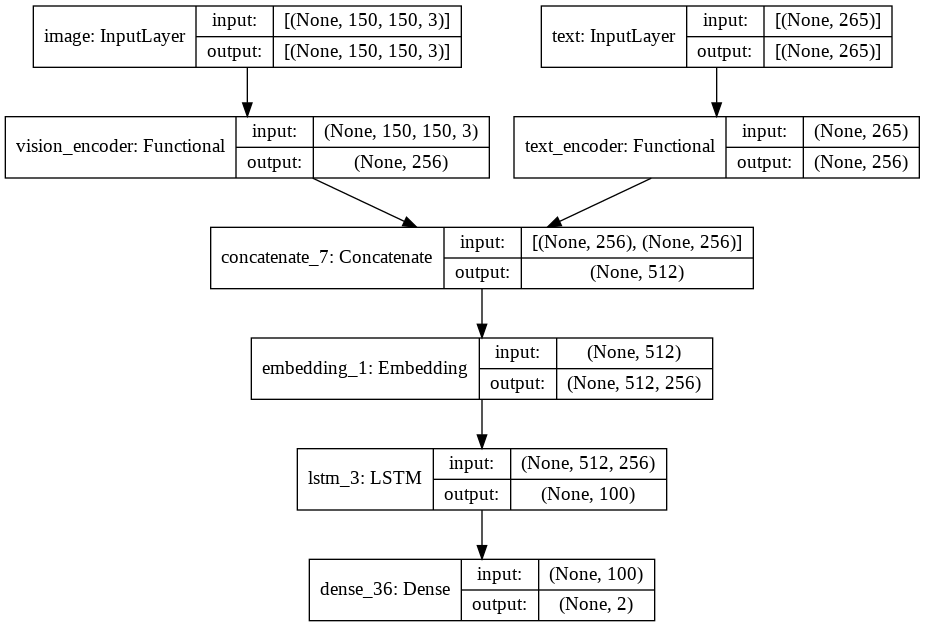

In [87]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image = keras.Input(shape=(150, 150, 3), name="image")

    # Receive the text as inputs.
    
    text_inputs = keras.Input(shape=(265,), name = 'text')

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder(image)
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    embeddings = keras.layers.Embedding(input_dim=512, output_dim=projection_dims)(concatenated)
    hidden= keras.layers.LSTM(units=100)(embeddings)
    outputs = keras.layers.Dense(2, activation="relu")(hidden)
    return keras.Model([image, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [94]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [95]:
multimodal_model.compile(
    optimizer=optimizer, loss="mae"
)



In [96]:
history = multimodal_model.fit(train_ds, epochs=10)

Epoch 1/10
474/474 [==============================] - 46s 88ms/step - loss: 0.6588
Epoch 2/10
474/474 [==============================] - 42s 88ms/step - loss: 0.6576
Epoch 3/10
474/474 [==============================] - 42s 88ms/step - loss: 0.6576
Epoch 4/10
474/474 [==============================] - 42s 88ms/step - loss: 0.6572
Epoch 5/10
474/474 [==============================] - 42s 88ms/step - loss: 0.6574
Epoch 6/10
474/474 [==============================] - 42s 88ms/step - loss: 0.6572
Epoch 7/10
474/474 [==============================] - 42s 89ms/step - loss: 0.6570
Epoch 8/10
474/474 [==============================] - 42s 89ms/step - loss: 0.6564
Epoch 9/10
474/474 [==============================] - 42s 89ms/step - loss: 0.6551
Epoch 10/10
474/474 [==============================] - 42s 89ms/step - loss: 0.6546


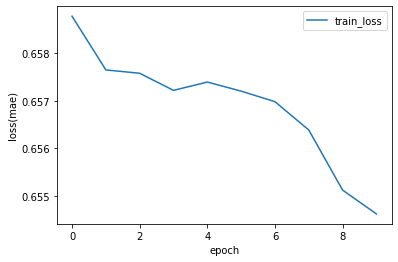

In [98]:
plt.plot(history.history['loss'], label='train_loss')
#plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()